<b><h1>IoTwins.bayesian_optimization service</h1></b>
The bayesian_optimization service developed in IoTwins is meant to support and allow clients to make hyperparameter fine-tuning.<br>This service can be used to automatically improve the performances of the already existing services as well as future services that will be developed and added in the IoTwins context. <br>
Why was this service developed? The IoTwins services are applicable in across a wide range of contexts and specifically in the area of anomaly detection.<br>
To work best, these services need specific and not always easy to find configurations that usually involve experts' work. The bayesian_optimization aims to remove this gap and allow any clients to automatically individuate the best hyperparameters configuration in an acceptable time.


The bayesian_optimization service is a wrapper of the <a href="https://github.com/hyperopt/hyperopt">Hyperopt</a> python library for serial and parallel optimization over awkward search spaces, which may include real-valued, discrete, and confitional dimensions.<br>
To conclude, the purpose of the service is to facilitate the use of the IoTwins services and make hyperparameter fine-tuning in the context of the client in the easiest and fastest manner. 

<b><h2>Optimization Example in IoTwins[bayesian_optimization service]</h2></b>
Formulating an optimization problem requires four main parts, two of which completly managed from the service:<br>
    - <b>Objective Function</b>[mandatory]: takes in an input and returns a loss to minimize.<br>
    - <b>Domain space</b>[mandatory]: the range of input values to evaluate.<br>
    - <b>Optimization Algorithm</b>[default <a href="https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf">tpe</a>]: the method used to construct the surrogate function and choose the next values to evaluate. <b>use the default value!</b><br>
    - <b>Results</b>[not mandatory]: score, value pairs that the algorithm uses to build the model. <b>Managed by the service</b>.<br>

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np
import os

# matplotlib for graphs
import matplotlib.pyplot as plt
import seaborn as sns

<b>Objective Function</b><br>
The <u>objective function</u> can be any function that returns a real value that we want to minimize.<br>
In addition, we usually also need the <u>saving model function</u> (not for this basic example).

In [2]:
def objective(x, verbose=0):  # I want to search the best 'x', the 'verbose' parameter is a fixed one
    """Objective function to minimize"""
    if verbose == 1:
        print("[objective] startig")
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    if verbose == 1:
        print("[objective] returning value")
    return f(x) * 0.05, {}, {}

save_model_f = None  # save_model_func parameter for the bayesian optimization service

Minimum of -219.8012 occurs at 4.8779


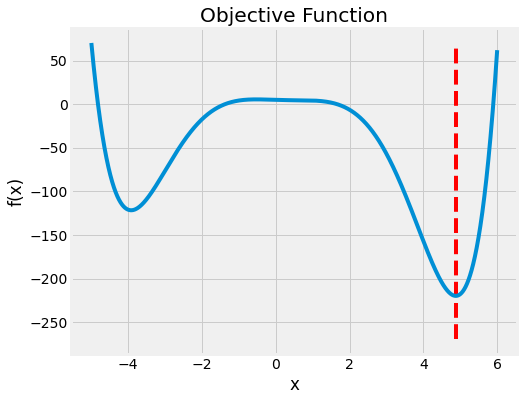

In [3]:
# TODO NASCONDERE INPUT
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y, _, _ = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

<b>Domain Space</b><br>
The domain space is the input values over which we want to search.<br>
This part may be the most difficult part to handle, however the bayesian_optimization service<br>
require the same space domain format as for the Hyperopt(<a href="http://hyperopt.github.io/hyperopt/getting-started/search_spaces/">How to define a Search Space</a>).<br>
<br>
Sometimes may be needed to pass fixed paramters to the objective function, parameters which are not part of the search space.<br>
This can be done passing a dict to the <i>"others_params"</i> bayesian_optimiztion's parameter.<br>
<br>
In our example we only have one parameter, the <i>x</i> value which can follow any kind of distribution, and one fixed parameter, the <i>verbose</i> parameter.

In [4]:
# TODO NASCONDERE INPUT
from hyperopt.pyll.stochastic import sample

def plot_distr(func, title='Domain Space'):
    samples = []

    # Sample 10000 values from the range
    for _ in range(10000):
        samples.append(sample(func))

    plt.figure()
    # Histogram of the values
    plt.hist(samples, bins = 20, edgecolor = 'black'); 
    plt.xlabel('x'); plt.ylabel('Frequency'); plt.title(title);

Uniform Distribution or Normal Distribution?


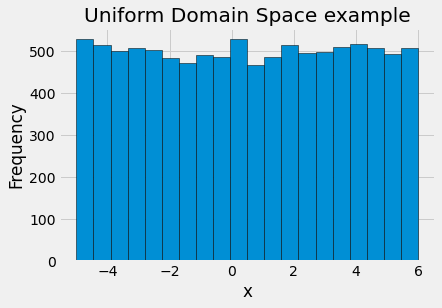

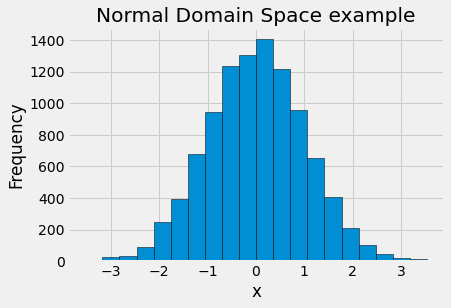

In [5]:
# TODO NASCONDERE INPUT
from hyperopt import hp
# Create the domain space
space = hp.uniform('x', -5, 6)  # how to define an uniform distribution for the 'x' parameter
space_normal = hp.normal('x', 0, 1)  # how to define a normal distribution for the 'x' parameter

print("Uniform Distribution or Normal Distribution?")
plot_distr(space, 'Uniform Domain Space example')
plot_distr(space_normal, 'Normal Domain Space example')

let's use the uniform distribution for <i>x</i>

In [6]:
# Domain Space
s = {'x': hp.uniform('x', -5, 6)}

# Fixed Parameters
o_p = {'verbose': 0}

<b>Optimization Algorithm</b> - Not Mandatory, managed by the service.<br>
As default the Tree-structured Parzen Estimator model is used inside the service, <br>
but it is possible to change it passing an algorithm to the <i>"opt_algorithm"</i> parameter.<br>
The service, and Hyperopt, support as default the: Random Search, Tree of Parzen Estimators (TPE) and Adaptive TPE. See <a href="Tree of Parzen Estimators (TPE)">Supported Algorithms</a>

In [7]:
# Not mandatory, as default the service uses the tpe as well
from hyperopt import tpe
# Create the algorithm
tpe_algo = tpe.suggest

<b>Results (Trials)</b> - not Mandatory, managed by the service<br>
This is not strictly necessary as Hyperopt keeps track of the results for the algorithm internally.<br>
However, since we want to inspect the progression of the alogorithm, the service creates a Trials object that will record the values and the scores.<br>

<b><h3>Optimization</h3></b><br>
Now that the problem is defined, we can minimize our objective function!<br>
To do so, we use the <i>bayesian_optimization</i> service that takes the four parts above, as well as a maximum number of evaluations:

In [8]:
from servises.super_semisuper_anomaly_detection_services.src.bayesianOptimization import bayesian_optimization, _load_trials
out_file = "semisup_ae_trials.csv"
t_e = 1000  # total_evals
best, trial_fname = bayesian_optimization(function_to_optimize=objective, trial_fname=out_file, space=s, 
                                          others_params=o_p, total_evals=t_e, save_model_func=None)

print("\n\ntrial_fname: {}".format(trial_fname))

print("BEST parameter/s:")
print(best)

Using TensorFlow backend.


100%|██████████| 1000/1000 [00:07<00:00, 137.35trial/s, best loss: -219.80118811219114]
[BO] trial saved


trial_fname: servises/super_semisuper_anomaly_detection_services/out/trials_1000_default_0.0.p
BEST parameter/s:
{'x': 4.878481851906148}


The best configuration founded for 'x' is different from the optimum value(4.8779) with 1000 evaluations.<br>
Keep searching increasing the number of evaluations starting from the previous run.<br>
We'll add 1000 evaluations reaching 2000 as total.

In [10]:
up_to_t_e = 2000
best, trial_fname = bayesian_optimization(function_to_optimize=objective, trial_fname=out_file, space=s, 
                                          others_params=o_p, total_evals=up_to_t_e, save_model_func=None,
                                          trials_name='trials_200_default_0.0')  # added the '' parameter for specifying a starting point

print("\n\ntrial_fname: {}".format(trial_fname))

print("BEST parameter/s:")
print(best)

[BO] trial loaded
100%|██████████| 2000/2000 [00:25<00:00, 71.02trial/s, best loss: -219.80119326488068]
[BO] trial saved


trial_fname: ../out/trials_2000_default_0.0.p
BEST parameter/s:
{'x': 4.877844315209165}


Running 1000 additional evaluations the best value founded is closer to the optimal one.

<b><h3>Results & Graphics</h3></b><br>
Let's have fun with the results visualization to better understand how the bayesian optimization works.

In [16]:
trial_filename, _ = os.path.splitext(trial_fname)
tpe_trials = _load_trials(trial_filename)

# Dataframe of results from optimization
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})

tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.loc[tpe_results['loss'] <= -218]


[BO] trial loaded


,loss,iteration,x,rolling_average_x,rolling_average_loss
21,-219.750785,21,4.897741,2.105103,-74.393795
22,-219.502010,22,4.925563,2.105103,-74.393795
51,-219.453289,51,4.825661,2.048959,-76.301309
65,-219.788976,65,4.887813,2.303696,-82.331683
82,-219.274998,82,4.813399,2.544681,-83.520051
...,...,...,...,...,...
1967,-219.684194,1967,4.847876,4.808622,-182.646872
1977,-219.759408,1977,4.860105,4.818343,-188.542228
1981,-219.224788,1981,4.810327,4.826547,-196.404725
1994,-218.876040,1994,4.791820,4.878945,-195.878225


Over time, the input values cluster around the optimal indicated by the red line.<br>
This is a simple problem, so the algorithm does not have much trouble finding the best value of x.

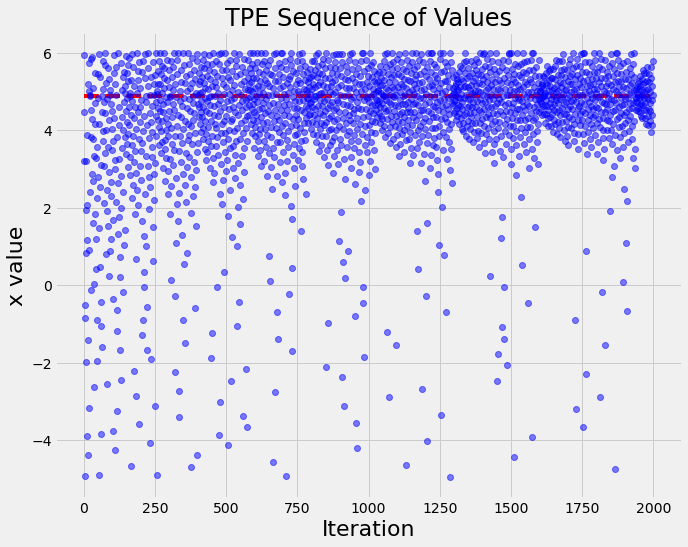

In [17]:
# TODO NASCONDERE INPUT
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

We can also plot the histogram to see the distribution of tested values.

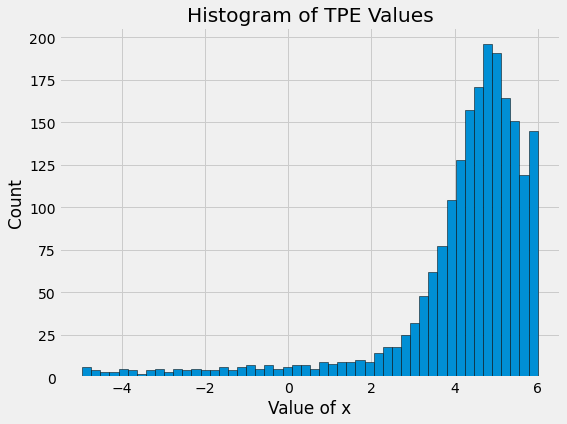

In [18]:
# TODO NASCONDERE INPUT
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

Best Loss of -219.8012 occured at iteration 1051


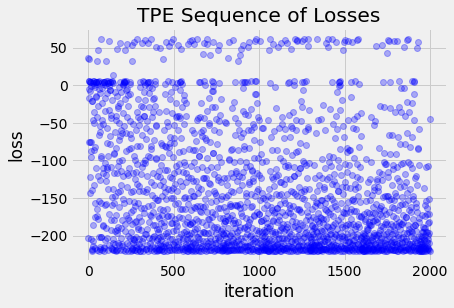

In [19]:
# TODO NASCONDERE INPUT
# Sort with best loss first
tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()

plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');

print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

Here we see the main benefit of Bayesian model-based optimization: more concentration on promising input values. When we are searching over dozens of parameters and each eval takes hours or days, reducing the number of evals is critical. Bayesian optimization minimizes the number of evals by reasoning based on previous results what input values should be tried in the future.

<b><h2>Conclusions</h2></b>

Bayesian model-based optimization is intuitive: choose the next input values to evaluate based on the past results to concentrate the search on more promising values. The end outcome is a reduction in the total number of search iterations compared to uninformed random or grid search methods.